In [1]:
import requests, json
from datetime import datetime, timedelta
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import pandas as pd
import shapely
from itertools import combinations, combinations_with_replacement

In [2]:
PROJECTION=32630

#### Station ridership

In [3]:
counts_en = pd.read_csv('/Users/itto/Documents/cities/data/london/counts/En17week_mod.csv', skiprows=6).set_index(' Station')
counts_ex = pd.read_csv('/Users/itto/Documents/cities/data/london/counts/Ex17week.csv', skiprows=6).set_index(' Station')

# We only care about the time columns
time_columns = counts_en.columns[4:-8]

# Easier to work with stations as columns, so transpose
data_en = counts_en.loc[:, time_columns].T
data_ex = counts_ex.loc[:, time_columns].T

# Remove "Total" column
data_en.drop('Total',axis=1,inplace=True)
data_ex.drop('Total',axis=1,inplace=True)

# Extract the first time
data_en.index = data_en.index.str[:4]
data_ex.index = data_en.index.str[:4]

# Convert to datetime format
data_en.index = pd.to_datetime(data_en.index, format='%H%M')
data_ex.index = pd.to_datetime(data_en.index, format='%H%M')

# Create a time of day index that we can use from now on
time_of_day_map = {
    6: 'morning',
    7: 'morning',
    8: 'morning',
    9: 'morning',
    10: 'off',
    11: 'off',
    12: 'off',
    13: 'off',
    14: 'off',
    15: 'off',
    16: 'afternoon',
    17: 'afternoon',
    18: 'afternoon',
    19: 'afternoon'
}
time_of_day = data_en.index.hour.map(time_of_day_map).to_series()
time_of_day[time_of_day.isnull()] = 'night'
time_of_day = time_of_day.values

In [4]:
# Get the entrances and exists for each time interval
entrances = data_en.groupby(time_of_day).sum().T
exits = data_ex.groupby(time_of_day).sum().T

In [5]:
entrances['total'] = entrances.afternoon + entrances.night + entrances.off + entrances.morning
entrances['morning_max'] = data_en.loc[time_of_day == 'morning'].max()
entrances['afternoon_max'] = data_en.loc[time_of_day == 'afternoon'].max()
entrances['off_mean'] = data_en.loc[time_of_day == 'off'].mean()

In [6]:
station_geom = gpd.read_file('../data/london/shapes/stations/stations_mod.shp')
# Change to UTM
station_geom.to_crs(epsg=PROJECTION, inplace=True)
# Remove the word "Station"
station_geom.columns = station_geom.columns.str.lower()
station_geom.rename(columns={'geometry':'location'}, inplace=True)
station_geom.name = station_geom.name.str.replace('\t','').str.replace('\n','').str.replace(' Station','')
station_geom.set_index('name', drop=True, inplace=True)

# Read Voronoi cells
station_voronoi = gpd.read_file('../data/london/shapes/stations/voronoi.shp')
station_voronoi.to_crs(epsg=PROJECTION, inplace=True)
station_voronoi.columns = station_voronoi.columns.str.lower()
station_voronoi.rename(columns={'geometry':'cell'}, inplace=True)
station_voronoi.name = station_voronoi.name.str.replace('\t','').str.replace('\n','').str.replace(' Station','')
station_voronoi.set_index('name', drop=True, inplace=True)

# Combine Voronoi with location
station_geom['cell'] = station_voronoi.reindex(station_geom.index).cell


#### Combine the data

In [7]:
# Combine entrances and station locations data
stations = pd.merge(station_geom, entrances, left_index=True, right_index=True)
stations['station'] = stations.index

#### Network

In [8]:
nodes = pd.read_csv('../data/london/network/nodes.csv')
nodes['geometry'] = [shapely.geometry.Point(p) for p in list(zip(nodes.longitude.values, nodes.latitude.values))]
nodes = gpd.GeoDataFrame(nodes)
nodes.crs = {'init' :'epsg:4326'}
nodes.to_crs(epsg= PROJECTION, inplace=True)

In [9]:
node_map = nodes.set_index('id')['geometry'].to_dict()

In [10]:
lines = pd.read_csv('../data/london/network/lines.csv')
lines['point1'] = lines.station1.map(node_map)
lines['point2'] = lines.station2.map(node_map)
lines = gpd.GeoDataFrame(lines)
lines.crs = nodes.crs

In [11]:
lines['geometry'] = ([shapely.geometry.LineString([p1,p2]) for (p1,p2) in lines[['point1','point2']].values])

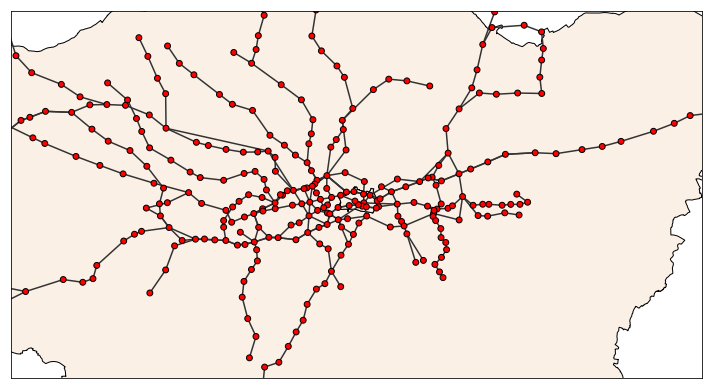

In [12]:
shp_london = gpd.read_file('../data/london/shapes/misc/london.shp')

f,(ax1) = plt.subplots(1,1, figsize=(10,10))
shp_london.plot(ax=ax1,color='linen',edgecolor='k',zorder=0)
lines.plot(ax=ax1, color=[0.2,0.2,0.2], zorder=1)
nodes.buffer(200).plot(ax=ax1, edgecolor='k', color='r')

ax1.set_xlim((678000,725000))
ax1.set_ylim((5699000,5724000))
ax1.set_xticks([])
ax1.set_yticks([])

f.tight_layout(w_pad=2)

In [13]:
%%latex
\begin{align}
residentiality = \frac{\max(R_{morning}) - \max(R_{afternoon})}{mean(R_{off peak})} ,\hspace{10mm}(2)
\end{align}

<IPython.core.display.Latex object>

In [14]:
data = data_en.T.reindex(stations.index).T
residentiality = (data.loc[time_of_day == 'morning'].max()
                  - data.loc[time_of_day == 'afternoon'].max())/data.loc[time_of_day == 'off'].mean()
residentiality_raw = (data.loc[time_of_day == 'morning'].max() - data.loc[time_of_day == 'afternoon'].max())

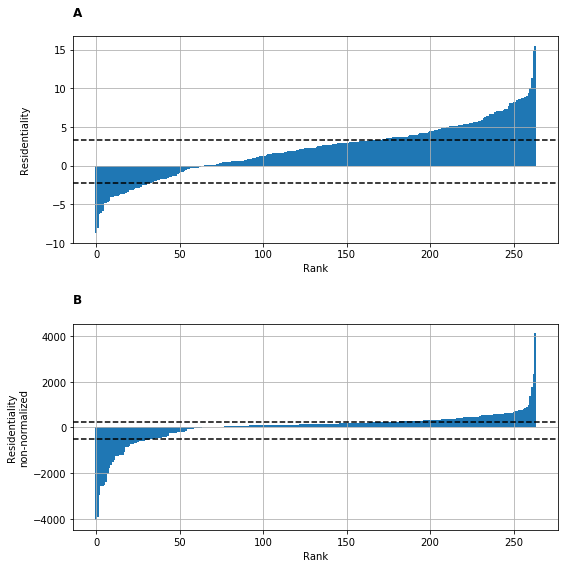

In [15]:
f,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
y = residentiality
y = y.sort_values()
ax1.bar(range(y.shape[0]),y,width=-1)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Residentiality\n');
line1 = residentiality[residentiality > 0].median()
line2 = residentiality[residentiality < 0].median()
ax1.axhline(line1,ls='--',color='k')
ax1.axhline(line2,ls='--',color='k')
ax1.set_title('A', loc='left',weight='bold', pad=20)
ax1.grid()

y = residentiality_raw
y = y.sort_values()
ax2.bar(range(y.shape[0]),y,width=-1)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Residentiality\nnon-normalized');
line1 = residentiality_raw[residentiality_raw > 0].median()
line2 = residentiality_raw[residentiality_raw < 0].median()
ax2.axhline(line1,ls='--',color='k')
ax2.axhline(line2,ls='--',color='k')
ax2.set_title('B', loc='left',weight='bold',pad=20)
ax2.grid()
f.tight_layout(h_pad=2)

In [961]:
%%time
ratios = np.arange(-5,9,1)
dist_set1 = []
dist_set2 = []
for i in ratios:
    set1 = residentiality[residentiality >= i].index
    set2 = residentiality[residentiality < i].index

    d1 = []
    d2 = []
    for j in set1:
        d = stations.set_geometry('location').reindex(set1).geometry.distance(stations.loc[j].location)
        d = d.loc[d != 0].mean()
        d1.append(d)
    dist_set1.append(np.array(d1).mean())
    for j in set2:
        d = stations.set_geometry('location').reindex(set2).geometry.distance(stations.loc[j].location)
        d = d.loc[d != 0].mean()
        d2.append(d)
    dist_set2.append(np.array(d2).mean())
    

CPU times: user 11.2 s, sys: 61.2 ms, total: 11.2 s
Wall time: 11.5 s


In [973]:
ratio = x[abs(y2-y1).argmax()]
set1 = stations.loc[residentiality >= ratio]
set2 = stations.loc[residentiality < ratio]

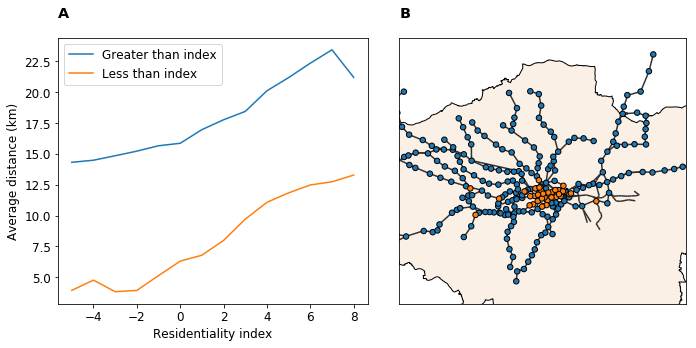

In [1183]:
f,(ax1,ax2) = plt.subplots(1,2,figsize = (10,5))

x = np.array(ratios)
y1 = np.array(dist_set1)/1000
y2 = np.array(dist_set2)/1000

ax1.plot(x,y1,label='Greater than index')
ax1.plot(x,y2,label='Less than index')

ax1.set_xlabel('Residentiality index')
ax1.set_ylabel('Average distance (km)')

ax1.legend(loc = 'upper left')

ax1.set_title('A', loc='left',weight='bold', pad=20)


shp_london = gpd.read_file('../data/london/shapes/misc/london.shp')
shp_london.plot(ax=ax2,color='linen',edgecolor='k',zorder=0)
lines.plot(ax=ax2, color=[0.2,0.2,0.2], zorder=1)

set1.set_geometry('location').buffer(400).plot(ax=ax2,edgecolor='k',color='C0')
set2.set_geometry('location').buffer(400).plot(ax=ax2,edgecolor='k',color='C1')
ax2.set_xlim((678000,720000))
ax2.set_ylim((5695000,5734000))
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_title('B', loc='left',weight='bold', pad=20)


f.tight_layout()



### Extract the hotspots

In [30]:
residents = (stations.morning - stations.off_mean*4*2)
residents[residents < 0] = 0
# residents -= residents.min()
workers = (stations.afternoon - stations.off_mean*4*2)
workers[workers < 0] = 0

In [31]:
hotspots_res = residents.sort_values().iloc[-20:].index
hotspots_work = workers.sort_values().iloc[-20:].index

hotspots_res = stations.reindex(hotspots_res)
hotspots_work = stations.reindex(hotspots_work)
hotspots_both = pd.merge(hotspots_res, hotspots_work[['cell']], left_index=True, right_index=True, how='inner')

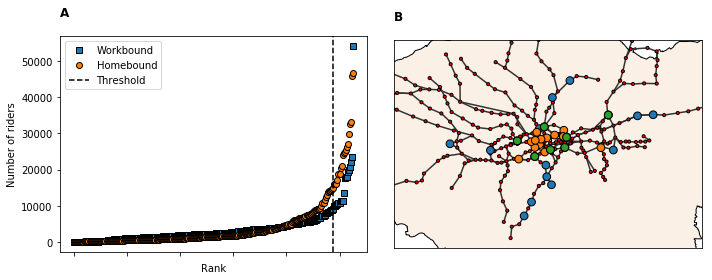

In [43]:
f,(ax1,ax2) = plt.subplots(1,2, figsize = (10,4))

residents.sort_values().plot(ax=ax1, style='.', markeredgecolor = 'k', marker='s', label = 'Workbound')
workers.sort_values().plot(ax=ax1, style='.',marker='o',markeredgecolor = 'k', label = 'Homebound')
ax1.axvline(residents.shape[0] - 20, c='k', ls='--', label='Threshold')
ax1.legend()

ax1.set_xlabel('Rank')
ax1.set_ylabel('Number of riders')

shp_london = gpd.read_file('../data/london/shapes/misc/london.shp')

shp_london.plot(ax=ax2,color='linen',edgecolor='k',zorder=0)
lines.plot(ax=ax2, color=[0.2,0.2,0.2], zorder=1)
nodes.buffer(200).plot(ax=ax2, edgecolor='k', color='r')

hotspots_res.set_geometry('location').buffer(500).plot(ax=ax2, edgecolor='k',color='C0')
hotspots_work.set_geometry('location').buffer(500).plot(ax=ax2, edgecolor='k', color='C1')
hotspots_both.set_geometry('location').buffer(500).plot(ax=ax2, edgecolor='k', color='C2')

ax2.set_xlim((680000,720000))
ax2.set_ylim((5697000,5724000))
ax2.set_xticks([])
ax2.set_yticks([])

ax1.set_title('A', loc='left',weight='bold', pad=20)
ax2.set_title('B', loc='left',weight='bold', pad=20)


f.tight_layout(w_pad=2)

In [14]:
def loubar(resource):
    x = range(resource.shape[0])
    y = (resource.sort_values()/resource.sum()).cumsum().values
    tangent_slope = (y[-1] - y[-2])/(x[-1] - x[-2])
    tangent_zero = x[-1] - y[-1]/tangent_slope  
    hotspots = resource.sort_values().iloc[x[np.ceil(tangent_zero).astype(int):]].index
    
    return hotspots, (x,y,tangent_slope, tangent_zero)

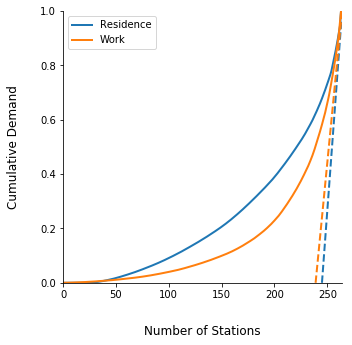

In [15]:
f,ax = plt.subplots(1,1, figsize=(5,5))

hotspots_res,(x,y,tangent_slope,tangent_zero) = loubar(residents)
ax.plot(y, 'C0',lw=2)
ax.plot([tangent_zero, y.shape[0]], [0, y[-1]], 'C0', ls='dashed', lw=2, label='_nolegend_')

hotspots_work,(x,y,tangent_slope,tangent_zero) = loubar(workers)
ax.plot(y, 'C1',lw=2)
ax.plot([tangent_zero, y.shape[0]], [0, y[-1]], 'C1', ls='dashed', lw=2, label='_nolegend_')

ax.legend(['Residence','Work'])
ax.set_xlabel('Number of Stations',labelpad=25, fontdict={'fontsize':12})
ax.set_ylabel('Cumulative Demand',labelpad=20, fontdict={'fontsize':12})


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.margins(0)

plt.rcParams.update({'font.size': 12})

### Create network of hotspots

In [586]:
hotspots = pd.concat([hotspots_res, hotspots_work])
hotspots = hotspots[~hotspots.index.duplicated()]

In [587]:
order_rows = residents.reindex(hotspots_res.index).sort_values().index
order_columns = workers.reindex(hotspots_work.index).sort_values().index

In [588]:
df = pd.DataFrame(index = order_rows, columns = order_columns)

In [590]:
df.loc[:,:] = 0
riders_morning = df.copy()
distance_morning = df.copy()
riders_afternoon = df.T.copy()
distance_afternoon = df.T.copy()

In [591]:
for i in hotspots_res.index:
    for j in hotspots_work.index:
        df.loc[i,j] = 1

### Ridership between hotspots

In [16]:
rods = pd.read_csv('../data/london/counts/rods.csv')

In [17]:
od = rods.set_index(['origin','destination'])
od_morning = rods.set_index(['origin','destination'])['morning']
od_midday = rods.set_index(['origin','destination'])['midday']
od_afternoon = rods.set_index(['origin','destination'])['afternoon']
od_evening = rods.set_index(['origin','destination'])['evening']

We are always assuming that homebound and workbound trips are symmetric: people who go to work should come back home the same way. This is a chance to this if this assumption is true.

In [18]:
od_x = od['morning'].unstack().fillna(0)
od_y = od['afternoon'].unstack().fillna(0)
trips_morning = []
trips_afternoon = []
for src in od_x.index:
    for dst in od_x.columns:
        if src in od_y.columns and dst in od_y.index:
            trips_morning.append(od_x.loc[src,dst])
            # Opposite direction in the afternoon
            trips_afternoon.append(od_y.loc[dst,src])

In [19]:
times = ['early','morning','midday','afternoon','evening','night']
pairs = list(combinations_with_replacement(times,2))

In [28]:
%%time
symmetry = pd.DataFrame(index=times, columns=times) 
for pair in pairs:
    if pair[0] == pair[1]:
        # Invalid to compare symmetry at the same time of day. Set symmetry as 0.
        symmetry.loc[pair[0],pair[1]] = 0
    else:
        od1 = od[pair[0]].unstack().fillna(0)
        od2 = od[pair[1]].unstack().fillna(0)
        trips1 = []
        trips2 = []
        for src in od1.index:
            for dst in od1.columns:
                if src in od2.columns and dst in od2.index:
                    trips1.append(od1.loc[src,dst])
                    # Opposite direction in the afternoon
                    trips2.append(od2.loc[dst,src])
        lin = linregress(trips1,trips2)
        symmetry.loc[pair[0],pair[1]] = lin[2]**2
        symmetry.loc[pair[1],pair[0]] = lin[2]**2

CPU times: user 20.2 s, sys: 92.8 ms, total: 20.3 s
Wall time: 20.4 s


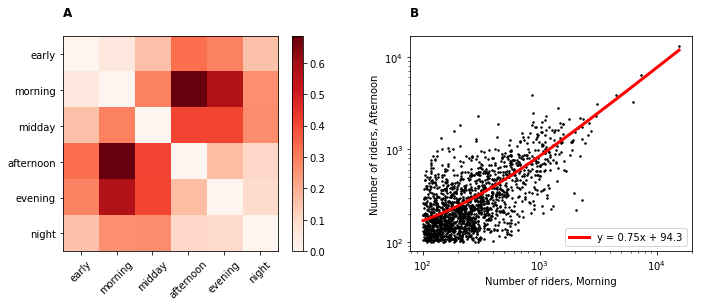

In [49]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4.2))
im = ax1.imshow(symmetry.astype('float'),cmap='Reds')
ax1.figure.colorbar(im, ax=ax1)
ax1.set_xticks(range(len(times)))
ax1.set_xticklabels(times)
ax1.set_yticks(range(len(times)));
ax1.set_yticklabels(times)
ax1.set_title('A', loc='left',weight='bold',pad=20)


for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

x = np.array(trips_morning)
y = np.array(trips_afternoon)

y = y[x > 100]
x = x[x > 100]
x = x[y > 100]
y = y[y > 100]

lin = linregress(x,y)
ax2.loglog(np.sort(x),np.sort(x)*lin[0]+lin[1],'r-', lw=3, label=f'y = {lin[0]:.2f}x + {lin[1]:.1f}',zorder=5)
ax2.legend(loc='lower right')
ax2.loglog(x,y,'k.',markersize=3)
ax2.set_xlabel('Number of riders, Morning')
ax2.set_ylabel('Number of riders, Afternoon');
ax2.set_title('B', loc='left',weight='bold',pad=20)

f.tight_layout(w_pad=4)

#### Visualize hotspot flows

In [617]:
for (origin,destination),riders in od.iterrows():
    # Exclude self-trips
    if origin != destination:
        # Check if this is a hotspot trip
        if (origin in hotspots.index) and (destination in hotspots.index):
            # Assign the value
            df.loc[origin, destination] = riders['total']
            # Check if this is a workbound trip
            if (origin in riders_morning.index) and (destination in riders_morning.columns):
                riders_morning.loc[origin, destination] = riders['morning']
                distance_morning.loc[origin, destination] = hotspots_res.loc[origin].location.distance(
                hotspots_work.loc[destination].location)
            # Check if it's a homebound trip
            if (origin in riders_afternoon.index) and (destination in riders_afternoon.columns):
                riders_afternoon.loc[origin, destination] = riders['afternoon']
# Replace zero distance with null
distance_morning.replace(0,np.nan,inplace=True)
# Distance is symmetric
distance_afternoon = distance_morning.T

In [1069]:
def show_od(od,ax,title,xlabel='Work hotspots',ylabel='Home hotspots'):
    im = ax.imshow(od,cmap='Reds')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, loc='left',weight='bold')
    ax.figure.colorbar(im, ax=ax) 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

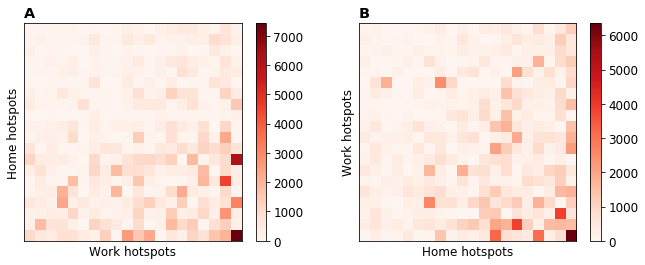

In [1072]:
f,(ax1,ax2) = plt.subplots(1,2, figsize = (11,4))
show_od(riders_morning.fillna(0),ax1,'A')
show_od(riders_afternoon.fillna(0),ax2,'B',xlabel='Home hotspots',ylabel='Work hotspots')

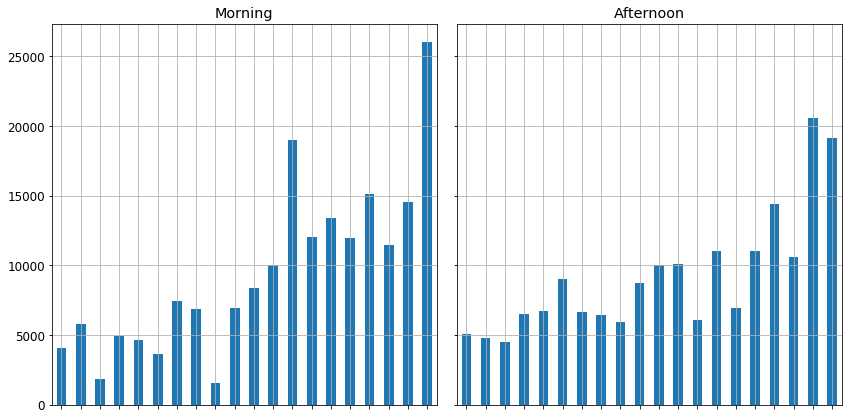

In [610]:
f,(ax1,ax2) = plt.subplots(1,2, figsize = (12,6), sharey=True)
riders_morning.sum(axis=1).plot(kind='bar', color='C0', ax=ax1)
ax1.set_title('Morning')
ax1.set_xticklabels([])
riders_afternoon.sum(axis=1).plot(kind='bar', color='C0', ax=ax2)
ax2.set_title('Afternoon')
ax2.set_xticklabels([])
f.tight_layout()
# f.suptitle('Number of hotspot trips', y=1.05)
ax1.grid()
ax2.grid()

In [825]:
od[['morning','afternoon']].sum().sum() / od.drop('total',axis=1).sum().sum()

0.53819338022275587

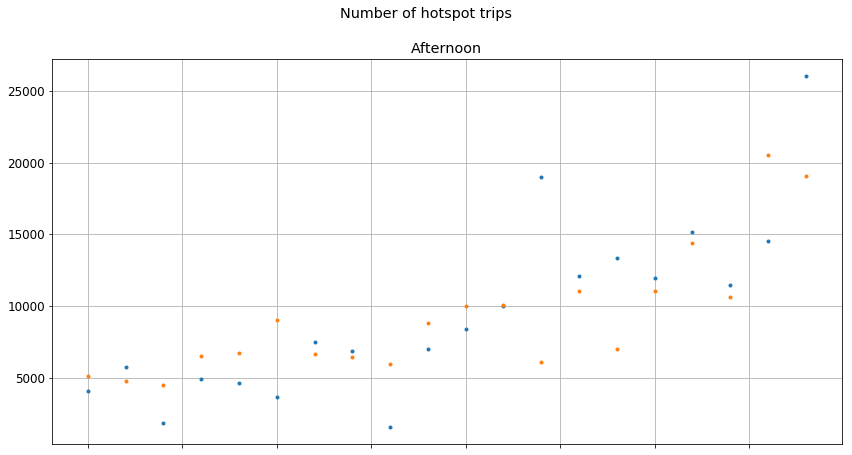

In [403]:
f,ax = plt.subplots(1,1, figsize = (12,6))
riders_morning.reindex(hotspots_res.index).sum(axis=1).plot(style='.', color='C0', ax=ax)
ax.set_title('Morning')
riders_afternoon.reindex(hotspots_work.index).sum(axis=1).plot(style='.', color='C1', ax=ax)
ax.set_title('Afternoon')
f.tight_layout()
f.suptitle('Number of hotspot trips', y=1.05)
ax.grid()

### Time analysis

In [544]:
df_routes = pd.read_csv('./output/routes.csv')

In [545]:
# Prepare a list of Res-Work pairs
# Coordinates
coords_a = hotspots_res.set_geometry('location').to_crs(epsg=4326).geometry
coords_b = hotspots_work.set_geometry('location').to_crs(epsg=4326).geometry
# Create table of coordinates
pairs = []
names = []
for nameA, pA in coords_a.iteritems():
    for nameB, pB in coords_b.iteritems():
        if nameA != nameB:
            # Check if we already got this previously
            if (nameA in df_routes.routeA.values) and (nameB in df_routes.routeB.values):
                continue
            pairs.append(((pA.y,pA.x),(pB.y,pB.x)))
            names.append((nameA, nameB))

In [547]:
time = datetime(2018,12,5,8,0).timestamp()
routes = get_routes(time, pairs, names)

Complete.


In [612]:
if len(routes):
    df_routes = pd.concat([df_routes,pd.concat(routes)])

In [537]:
df_routes.to_csv('./output/routes.csv', index=False)

In [549]:
df_routes = df_routes.loc[df_routes.other_providers.isnull()]

In [550]:
od_times = df_routes.groupby(['routeA','routeB']).length.min().unstack()
od_times = od_times.reindex(residents.reindex(hotspots_res.index).sort_values().index)
od_times = od_times.T.reindex(workers.reindex(hotspots_work.index).sort_values().index)
od_times = od_times.T

[]

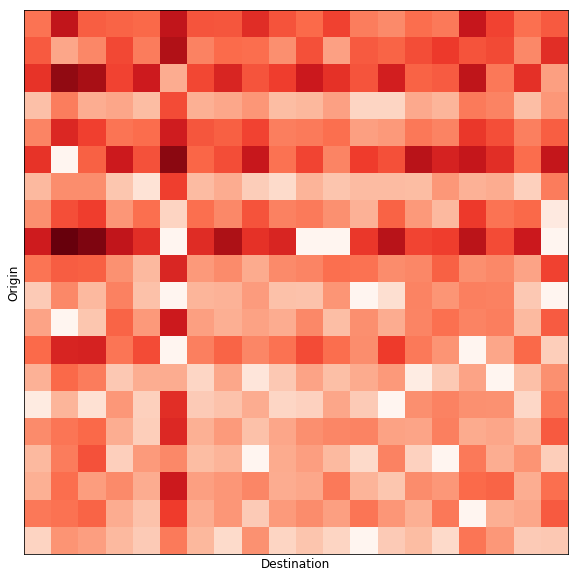

In [552]:
f,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(od_times.fillna(0), cmap='Reds')
ax.set_ylabel('Origin')
ax.set_yticks([])
ax.set_xlabel('Destination')
ax.set_xticks([])

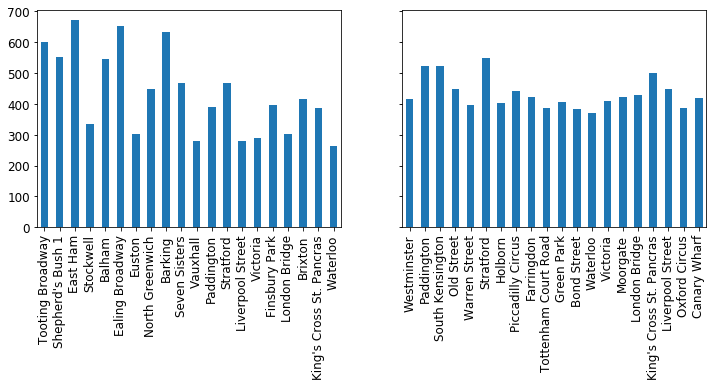

In [553]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4), sharey=True)
od_times.sum(axis=1).plot(ax=ax1,kind='bar',color='C0')
od_times.sum(axis=0).plot(ax=ax2,kind='bar',color='C0')

### Combine Time and Ridership

In [640]:
od_riders = riders_morning.copy()
od_distances = distance_morning.copy()

In [664]:
speed = (od_distances).div(od_times*60)
performance = od_riders.div(speed)

In [1270]:
%%latex
\begin{align}
PTS_{ij} = \frac{R_{ij}}{v_{ij}} ,\hspace{10mm}(6)
\end{align}

<IPython.core.display.Latex object>

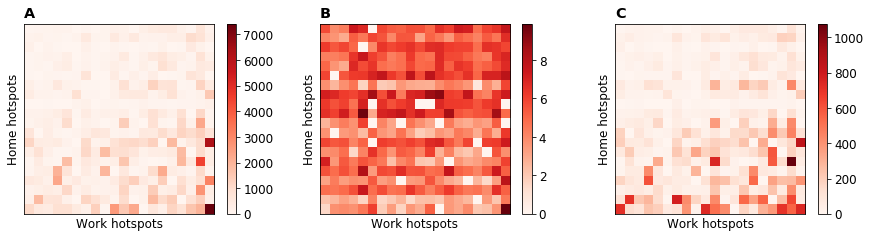

In [1062]:
plt.rcParams.update({'font.size': 12})
f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,3.5), sharey=True)
show_od(od_riders.fillna(0),ax1,'A')
show_od(speed.fillna(0),ax2,'B')
show_od(performance.fillna(0),ax3,'C')

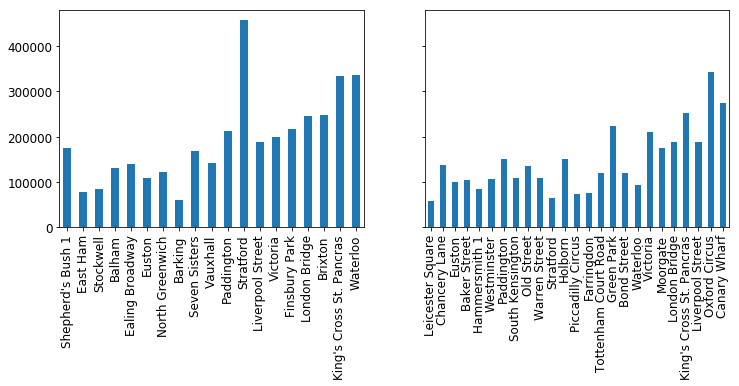

In [147]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4), sharey=True)
performance.replace(np.inf,np.nan).sum(axis=1).plot(ax=ax1,kind='bar',color='C0')
performance.sum(axis=0).plot(ax=ax2,kind='bar',color='C0')

Text(0.5,1,'Route Efficiency, by origin station')

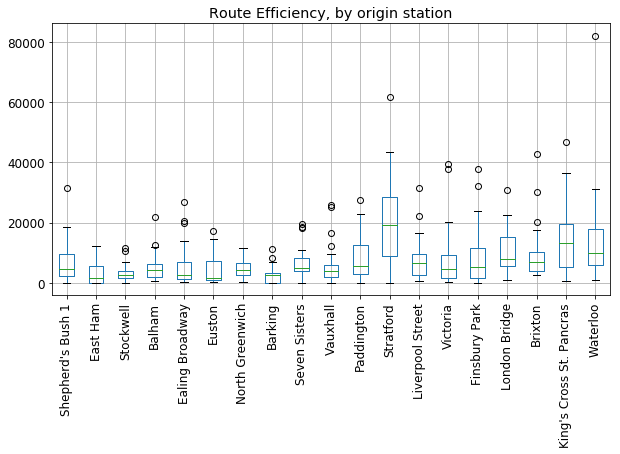

In [148]:
f,ax1 = plt.subplots(1,1,figsize = (10,5))
performance.T.boxplot(ax=ax1)
plt.xticks(rotation='vertical');
ax1.set_title('Route Efficiency, by origin station')

In [517]:
def get_routes(depart_time, pairs, names):
    url = 'https://api.tripgo.com/v1/'
    
    headers = {
    'Accept': 'application/json',
    'X-TripGo-Key': '5c1a480843464d538b24939c266be8b9',
    }
    
    segments = []
    routes = []
    errors = []
    for i,pair in enumerate(pairs):
        try:
            print('Routing: from {} to {}'.format(names[i][0], names[i][1]))
            p2 = pair[0]
            p1 = pair[1]
            direction = i%2 # 0 for To and 1 for Return
            # Set up request
            params = (
                ('from', str(p2)),
                ('to', str(p1)),
                ('modes', 'pt_pub'),
                ('v', '11'),
                ('locale', 'en'),
                ('departAfter', depart_time - 1) #Subtract 1 since it's actually "depart after"
            )

            # Make request
            response = requests.get('https://api.tripgo.com/v1/routing.json', headers=headers, params=params)

            routing = json.loads(response.text)
            segs = pd.DataFrame(routing['segmentTemplates'])
            segs['route'] = int(i/2)
            segs['direction'] = direction
            segs['routeA'] = names[i][0]
            segs['routeB'] = names[i][1]
            segments.append(segs)

            # For all groups
            for j,group in enumerate(routing['groups']):
                df = pd.DataFrame(group['trips'])
                # Meta data
                df['route'] = int(i/2)
                df['direction'] = direction
                df['routeA'] = names[i][0]
                df['routeB'] = names[i][1]
                df['group'] = j
                df['num_segments'] = df.segments.apply(len)
                # Preliminary processing
                df['length'] = (df.arrive - df.depart)/60
                df['depart_time'] = df.depart.apply(datetime.fromtimestamp)
                df['arrive_time'] = df.arrive.apply(datetime.fromtimestamp)
                # Check if it's a completely underground route
                providers = ''
                for source in routing['groups'][j]['sources']:
                    name = source['provider']['name']
                    if ('Underground' not in name) and ('OpenStreetMap' not in name) and ('London Overground' not in name):
                        if len(providers):
                            providers += ', '
                        providers += name
                if providers == '':
                    # No other providers
                    providers = np.nan
                df['other_providers'] = providers
                routes.append(df)
        except Exception as e:
            print('Could no complete: {} to {}'.format(names[i][0],names[i][1]))
            print('Reason: ',e)
            errors.append(names[i])
            pass
    print('Complete.')
    return routes

In [666]:
speed

,Westminster,Paddington,South Kensington,Old Street,Warren Street,Stratford,Holborn,Piccadilly Circus,Farringdon,Tottenham Court Road,Green Park,Bond Street,Waterloo,Victoria,Moorgate,London Bridge,King's Cross St. Pancras,Liverpool Street,Oxford Circus,Canary Wharf
Tooting Broadway,5.744827,3.896148,4.340456,7.404457,6.813334,NaN,5.866878,5.309476,5.162804,5.658856,5.625240,4.962584,6.541219,6.060460,7.340583,7.129923,4.818858,5.985842,6.424117,7.674283
Shepherd's Bush 1,4.055622,3.639479,2.945414,5.228689,4.514663,5.939461,5.500639,4.050340,5.464067,5.415158,3.162863,5.101055,4.486129,3.519371,5.195837,4.774750,4.210682,5.333670,4.599073,6.669919
East Ham,6.186493,5.433557,5.906843,5.008534,NaN,4.019904,6.352598,5.874312,6.170451,6.475666,5.806266,6.686403,6.764360,6.159325,6.000601,5.972084,4.823877,6.558862,6.391587,5.879332
Stockwell,4.288111,4.271819,4.566060,6.388059,7.533351,6.076484,5.527816,4.261268,4.719975,6.226838,4.924386,4.683467,6.743450,5.802586,5.781503,5.188719,4.487214,4.250391,6.378362,6.949182
Balham,5.009132,3.649223,2.952214,6.823004,5.750984,6.401005,4.815794,4.456400,4.742166,5.872225,4.922920,5.042532,6.709892,5.219313,6.439512,6.137829,4.819880,5.194535,5.787884,6.732762
Ealing Broadway,5.915582,NaN,5.451879,6.207809,6.263398,7.035872,7.670280,6.272116,5.589676,7.778159,5.717316,7.866409,6.514817,6.084232,5.664593,6.504706,5.030284,7.018134,7.031587,7.903855
Euston,3.787544,2.619933,3.811885,4.612808,1.679727,4.605864,1.942591,2.170965,3.533263,3.044812,2.872350,2.826702,3.877954,4.550165,4.159549,3.591071,0.760631,3.885265,2.810567,5.889874
North Greenwich,7.164159,6.805378,6.177577,5.940216,6.595114,8.615487,5.674480,7.415987,4.375058,6.918741,7.075439,8.764179,9.150426,6.137463,5.923943,7.672622,4.660971,4.174403,6.350349,7.336246
Barking,6.272151,5.582692,6.002223,4.685628,7.082713,NaN,6.499190,5.607616,6.170979,6.602461,NaN,NaN,6.839761,6.257843,6.209221,6.146741,5.524635,6.204618,6.520215,NaN
Seven Sisters,6.556431,6.063858,7.199338,5.336484,9.696811,2.983585,7.028900,7.216123,7.670060,6.557234,7.324971,6.058678,6.093710,8.555610,5.563297,5.206319,5.548637,5.663873,8.647955,4.896974
